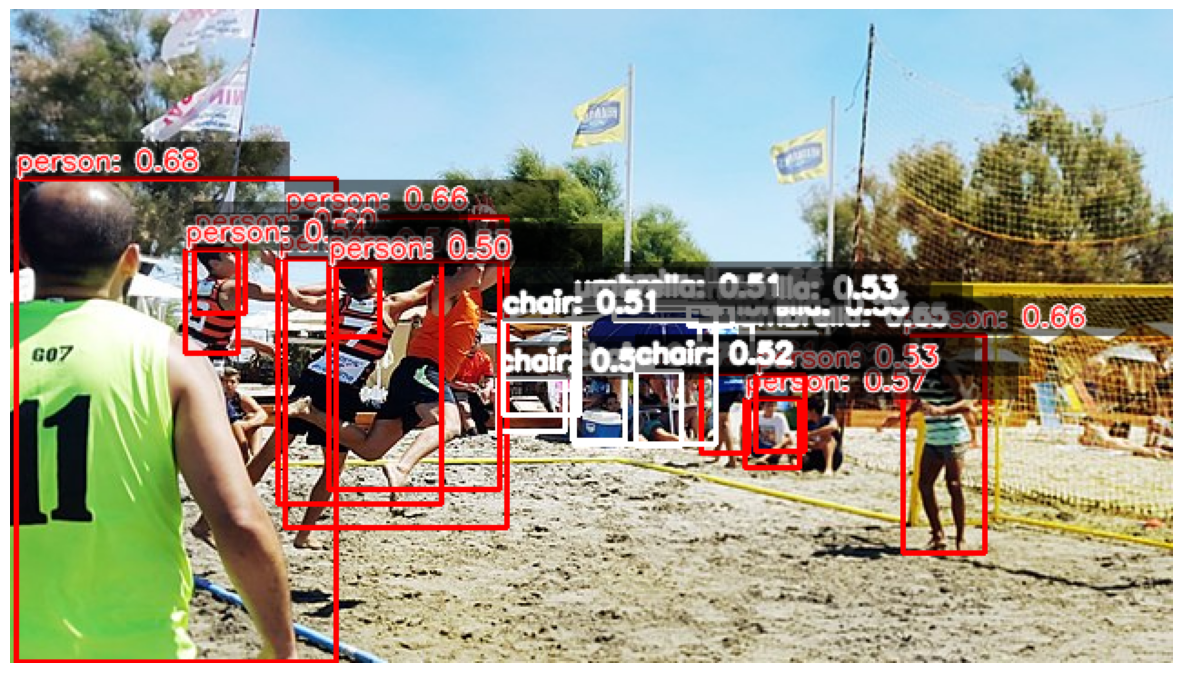

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt
import urllib.request

# SSD 모델 불러오기
ssd_model = hub.load('https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2')

# URL에서 이미지 불러오기
image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Torneo_beach_handball.jpg/640px-Torneo_beach_handball.jpg'

# URL에서 이미지 다운로드
with urllib.request.urlopen(image_url) as response:
    img_array = np.asarray(bytearray(response.read()), dtype=np.uint8)
    image = cv2.imdecode(img_array, -1)

# RGB로 변환
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 이미지 변환 및 전처리
image_tensor = tf.convert_to_tensor(image_rgb)
image_tensor = tf.image.convert_image_dtype(image_tensor, dtype=tf.uint8)[tf.newaxis, ...]

# 모델로 추론
result = ssd_model(image_tensor)

# 결과 얻기 (탐지된 박스, 클래스, 점수)
boxes = result['detection_boxes'].numpy()
classes = result['detection_classes'].numpy()
scores = result['detection_scores'].numpy()

# 클래스 이름 (COCO 데이터셋 클래스들)
labels = {
    1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck',
    9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench',
    16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear',
    24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase',
    34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat',
    40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass',
    47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich',
    55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake',
    62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet',
    72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'microwave',
    79: 'oven', 80: 'toaster', 81: 'sink', 82: 'refrigerator', 84: 'book', 85: 'clock', 86: 'vase',
    87: 'scissors', 88: 'teddy bear', 89: 'hair drier', 90: 'toothbrush'
}

# 클래스 ID에 따른 색상 정의 (BGR 형식)
class_colors = {
    1: (255, 0, 0), 2: (0, 255, 0), 3: (0, 0, 255), 4: (255, 255, 0), 5: (255, 0, 255),
    6: (0, 255, 255), 7: (128, 0, 128), 8: (128, 128, 0), 9: (0, 128, 128), 10: (128, 128, 128)
}

# 박스를 그려주는 함수 정의
def draw_boxes(image, boxes, scores, classes, labels, colors, threshold=0.5):
    height, width, _ = image.shape
    for i in range(len(boxes[0])):  # Access the first dimension of boxes
        if scores[0][i] >= threshold:  # Access the first dimension of scores and then the element
            box = boxes[0][i]  # Access the first dimension of boxes and then the box
            y_min, x_min, y_max, x_max = box
            start_point = (int(x_min * width), int(y_min * height))
            end_point = (int(x_max * width), int(y_max * height))

            # 해당 클래스의 색상 가져오기
            class_id = int(classes[0][i])
            color = colors.get(class_id, (255, 255, 255))  # 색상이 없으면 흰색

            # 박스 그리기
            image = cv2.rectangle(image, start_point, end_point, color, 2)

            # 클래스와 점수 텍스트 추가
            label = labels.get(class_id, 'Unknown')
            score = scores[0][i]
            text = f'{label}: {score:.2f}'

            # 텍스트 배경을 반투명하게 그리기
            overlay = image.copy()
            text_background_start = (start_point[0], start_point[1] - 20)
            text_background_end = (start_point[0] + 150, start_point[1])
            cv2.rectangle(overlay, text_background_start, text_background_end, (0, 0, 0), -1)  # 검은색 배경
            cv2.addWeighted(overlay, 0.5, image, 0.5, 0, image)  # 반투명 효과

            # 텍스트 그리기 (윤곽선 추가)
            image = cv2.putText(image, text, (start_point[0], start_point[1] - 5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)  # 흰색 글자
            image = cv2.putText(image, text, (start_point[0], start_point[1] - 5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)  # 색상이 있는 윤곽선
    return image

# 박스 및 설명 텍스트 그리기
output_image = draw_boxes(image_rgb, boxes, scores, classes, labels, class_colors)

# 결과 시각화
plt.figure(figsize=(15, 10))  # 이미지 크기를 10x8로 조정
plt.imshow(output_image)
plt.axis('off')
plt.show()